In [1]:
# Notes
# Batch size 32-128
# lr <= 0.0001 for relu
# if we want more data so training > test, can use data augmentation
# experimented with some dropout layers to prevent overfitting, low probability on conv layers, 0.4+ on fc layers
# relu, CrossEntropy and Adam seem to make most sense

In [2]:
import torch, time, gc
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f'Using {torch.cuda.get_device_name(0)}')
SAVE_PATH = "./neural_net.pth"

# Training variables
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.00005

# Define the transforms for the dataset
transform = transforms.Compose([
    transforms.Resize(256, antialias=True),  # had an error if I didn't set this antialias, but don't think it's needed
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),  # 50% chance to flip img
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the train and test datasets
train_dataset = datasets.Flowers102(root="./data", split="train", transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataset = datasets.Flowers102(root="./data", split="test", transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
val_dataset = datasets.Flowers102(root="./data", split="val", transform=transform, download=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

val_accuracies = []


# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2)) # 224 -> 112
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                  #  nn.Dropout(0),
                                   nn.MaxPool2d(2, 2)) # 112 -> 56
        self.conv3 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2)) # 56 -> 28
        self.conv5 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(),
                                  #  nn.Dropout(0)
                                   )
        self.conv6 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU())
        self.conv7 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2)) # 28 -> 14
        self.fc1 = nn.Sequential(nn.Linear(14 * 14 * 256, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.6))
        self.fc2 = nn.Sequential(nn.Linear(4096, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.6))
        self.fc3 = nn.Sequential(nn.Linear(4096, 102))

        # Final output_features size must be 102 as there are 102 labels in the dataset
        # Pool dimensions: out=(in-kernel)/stride + 1

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = x.view(-1, 14 * 14 * 256)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [3]:
# Clear cuda cache
gc.collect()
torch.cuda.empty_cache()

# Create an instance of the CNN and move it to the device
cnn = CNN().to(device)
print(cnn)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReL

In [4]:
# Setup timer
start_time = time.time()

# Train the CNN
for epoch in range(EPOCHS):
    cnn.train()
    for i, (images, labels) in enumerate(train_loader):
        
        labels = torch.eye(102)[labels] # one hot encode
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn(images) # train

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 16 == 0:
            print(f"Epoch [{epoch + 1}/{EPOCHS}], Step [{i + 1}/{len(train_loader)}], Step Loss: {loss.item():.4f}")

    # Evaluate model after each training epoch
    cnn.eval()
    with torch.no_grad():
        # training accuracy
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{EPOCHS}], Training Accuracy: {accuracy:.2f}%')

        # validation accuracy
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{EPOCHS}], Validation Accuracy: {accuracy:.2f}%')

    # save accuracy
    val_accuracies.append(accuracy)

# Output time taken to train
end_time = time.time()
print("Training Complete in: " + time.strftime("%Hh %Mm %Ss", time.gmtime(end_time - start_time)))

Epoch [1/30], Step [16/32], Step Loss: 5.5231
Epoch [1/30], Step [32/32], Step Loss: 4.8631
Epoch [1/30], Training Accuracy: 3.73%
Epoch [1/30], Validation Accuracy: 2.06%
Epoch [2/30], Step [16/32], Step Loss: 4.7204
Epoch [2/30], Step [32/32], Step Loss: 4.4636
Epoch [2/30], Training Accuracy: 6.18%
Epoch [2/30], Validation Accuracy: 4.80%
Epoch [3/30], Step [16/32], Step Loss: 4.5780
Epoch [3/30], Step [32/32], Step Loss: 4.3861
Epoch [3/30], Training Accuracy: 7.75%
Epoch [3/30], Validation Accuracy: 6.18%
Epoch [4/30], Step [16/32], Step Loss: 4.1494
Epoch [4/30], Step [32/32], Step Loss: 4.8848
Epoch [4/30], Training Accuracy: 11.08%
Epoch [4/30], Validation Accuracy: 7.65%
Epoch [5/30], Step [16/32], Step Loss: 4.3629
Epoch [5/30], Step [32/32], Step Loss: 4.2012
Epoch [5/30], Training Accuracy: 10.98%
Epoch [5/30], Validation Accuracy: 7.06%
Epoch [6/30], Step [16/32], Step Loss: 4.1966
Epoch [6/30], Step [32/32], Step Loss: 4.2778
Epoch [6/30], Training Accuracy: 16.08%
Epoch 

In [5]:
# Save network
torch.save(cnn.state_dict(), SAVE_PATH)
print("NN saved.")

NN saved.


In [6]:
# Test the CNN with all testing data
cnn = CNN().to(device)
cnn.load_state_dict(torch.load(SAVE_PATH))
print("NN loaded.")

cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        pred_labels = torch.argmax(outputs, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {(100 * correct / total):.2f}%")

NN loaded.
Test Accuracy: 35.01%


In [7]:
# Test with CNN with all training data
cnn = CNN().to(device)
cnn.load_state_dict(torch.load(SAVE_PATH))
print("NN loaded.")

cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        pred_labels = torch.argmax(outputs, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {(100 * correct / total):.2f}%")

NN loaded.
Train Accuracy: 73.24%


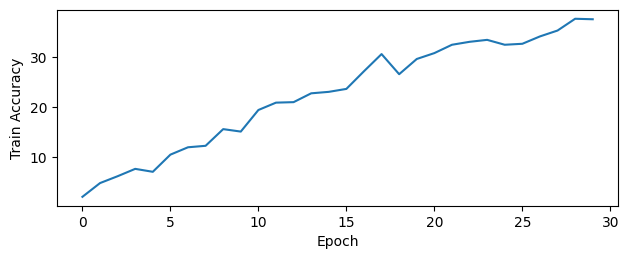

In [8]:
# Plot
fig = plt.figure(tight_layout=True)
gs = grid.GridSpec(nrows=2, ncols=1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(val_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Train Accuracy")

fig.align_labels()
plt.show()


*   No aug: 28.95%
*   Horizontal Flip: 35.52%
*   Horizontal Flip + Rotation: 39.75%
*   Horizontal Flip + Rotation + No Cropping: 36.56%

**Horizontal Flip + Rotation**
Exploring dropout and batchnorm2d...

*   Dropout 0.3 on linear layers: 40.32%
*   Dropout 0.6 on linear layers: 35.01% (no real plateau at 30 epochs, maybe try for longer)



